<div align="center">

![Cover image](./assets/cover-img.png)

</div>

> Image generated using Google Gemini

# Bank Customer Churn Prediction

## Introduction
This notebook addresses the critical business challenge of **customer churn** in the banking sector. Our objectives are:

- **Identify and visualize** the key factors influencing customer churn.
- **Develop a predictive model** to classify customers as likely to churn or not.
- **Generate actionable insights** for the marketing team by producing a **monthly top-K list of high-risk customers** who should be proactively targeted for retention.

### Business Problem
Customer churn directly impacts revenue and profitability. The core question we aim to answer is:
**"Which customers are most likely to churn, and how can we prioritize retention efforts to maximize ROI?"**

By leveraging predictive analytics, we will enable the bank to focus its retention resources on customers with the highest risk of attrition, thereby reducing unnecessary outreach and improving cost efficiency.

---

## Key Business Metrics
To evaluate the effectiveness of our model, we will focus on the following metrics:
- **Recall@K:** Measures the proportion of actual churners identified within the top K high-risk customers targeted for retention.
- **PR-AUC (Precision-Recall Area Under the Curve):** A robust metric for imbalanced datasets, ensuring our model performs well even when churners are a minority.
- **Expected Incremental Revenue per Retained Customer:** Estimates the return on investment (ROI) for retention efforts, helping the bank allocate resources effectively.

---

## Dataset Overview
The dataset contains customer-level information, including demographic, behavioral, and transactional attributes. Below is a description of the features:

| Feature              | Description                                                                                     |
|----------------------|-------------------------------------------------------------------------------------------------|
| **RowNumber**        | Record (row) number; irrelevant for predictive modeling.                                        |
| **CustomerId**       | Unique identifier for each customer; irrelevant for churn prediction.                           |
| **Surname**          | Customer surname; not expected to influence churn.                                             |
| **CreditScore**      | Customer’s credit score; higher scores may correlate with lower churn likelihood.                |
| **Geography**        | Customer location; regional differences may impact churn rates.                                |
| **Gender**           | Customer gender; potential influence on churn behavior.                                        |
| **Age**              | Customer age; older customers tend to exhibit higher loyalty.                                  |
| **Tenure**           | Number of years as a bank customer; longer tenure often indicates lower churn risk.             |
| **Balance**          | Account balance; higher balances may correlate with lower churn likelihood.                     |
| **NumOfProducts**    | Number of bank products used; higher engagement may reduce churn risk.                          |
| **HasCrCard**        | Indicates credit card ownership; cardholders may be less likely to churn.                       |
| **IsActiveMember**   | Active membership status; active customers are less likely to leave.                           |
| **EstimatedSalary**  | Estimated income; lower salaries may correlate with higher churn risk.                          |
| **Exited**           | **Target variable:** Binary indicator (1 = churned, 0 = retained).                             |
| **Complain**         | Indicates whether the customer has registered a complaint.                                     |
| **SatisfactionScore**| Customer rating of complaint resolution; lower scores may signal dissatisfaction and churn risk.|
| **CardType**         | Type of credit card held; may influence customer loyalty.                                      |
| **PointsEarned**     | Rewards points accumulated; higher engagement may reduce churn likelihood.                     |

---

> Features and description provided by bank

## Importing libraries and setting up configs

In [34]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Constants
RANDOM_STATE = 42
DATA_DIR = Path.cwd().parent / 'data' / 'raw'
DATA_FILE = DATA_DIR / 'Customer-Churn-Records.csv'

# Configs
warnings.filterwarnings("ignore")

# pandas config
pd.set_option('display.float_format', '{:.2f}'.format)

# Data visualization
plt.style.use('seaborn-v0_8-darkgrid')

colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#BC4B51']
sns.set_palette(colors)

plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['figure.facecolor'] = '#FAFAFA'
plt.rcParams['axes.facecolor'] = '#FFFFFF'

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'medium'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.title_fontsize'] = 11

# Grid styling - subtle and clean
plt.rcParams['grid.color'] = '#E5E5E5'
plt.rcParams['grid.linewidth'] = 0.8
plt.rcParams['grid.alpha'] = 0.6

# Spine and border styling
plt.rcParams['axes.edgecolor'] = '#CCCCCC'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Line and marker styling
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['lines.markersize'] = 8
plt.rcParams['patch.linewidth'] = 0.5

# Legend styling
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.framealpha'] = 0.95
plt.rcParams['legend.fancybox'] = True
plt.rcParams['legend.shadow'] = False

# Seaborn context for better scaling
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2.5})


In [ ]:
df = pd.read_csv(DATA_FILE, low_memory=False)

In [35]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,GOLD,425


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

## Preliminary Data Inspection

After loading the dataset and performing initial checks; the following observations were made:

- **Dataset Shape:** 10,000 rows and 18 columns.
- **Variable Types:** A mix of numeric (`int`, `float`) and categorical (`object`) variables.
- **Missing Values:** None detected.
- **Irrelevant Columns:** The columns `RowNumber`, `Surname`, and `CustomerId` do not contribute to the predictive analysis and can be safely removed.

#### Criteria for Removing Columns

The following columns were identified as irrelevant for predictive modeling based on these criteria:

1. **`RowNumber`**
   - **Reason:** This column is an artificial index assigned to each row in the dataset. It does not represent any meaningful feature or attribute of the customer and has no predictive value.

2. **`Surname`**
   - **Reason:** While `Surname` is a categorical variable, it is highly unlikely to have a meaningful correlation with customer churn. Surnames are unique identifiers tied to individual identity rather than behavior, demographics, or financial attributes. Including this column could introduce noise or bias into the model without providing actionable insights.

3. **`CustomerId`**
   - **Reason:** Similar to `RowNumber`, `CustomerId` is a unique identifier assigned to each customer for administrative purposes. It does not contain any information about customer behavior, demographics, or financial status, and thus cannot contribute to predicting churn.

**Conclusion/Action**: These columns do not provide any predictive signal and can be safely removed to simplify the dataset and improve model efficiency.


In [ ]:
print("Shape before dropping ID columns:", df.shape)

drop_cols = ["RowNumber", "CustomerId", "Surname"]
present_to_drop = [c for c in drop_cols if c in df.columns]

if present_to_drop:
    print("\nDropping columns (IDs):", present_to_drop)
df = df.drop(columns=present_to_drop, errors="ignore")

print("\nShape after dropping leakage and ID columns:", df.shape)

Shape before dropping ID columns: (10000, 18)

Dropping columns (IDs): ['RowNumber', 'CustomerId', 'Surname']

Shape after dropping leakage and ID columns: (10000, 15)


In [ ]:
# Check for unexpected data types
numeric_cols = df.select_dtypes(include=[np.number])
object_cols = df.select_dtypes(include=['object'])

print(f"Numeric columns: {len(numeric_cols.columns)}")
print(f"\nObject columns:  {len(object_cols.columns)}")
print(f"\nObject columns list: {list(object_cols.columns)}")

Numeric columns: 12

Object columns:  3

Object columns list: ['Geography', 'Gender', 'Card Type']


In [ ]:
print("Unique Count")
df.nunique()

Unique Count


CreditScore            460
Geography                3
Gender                   2
Age                     70
Tenure                  11
Balance               6382
NumOfProducts            4
HasCrCard                2
IsActiveMember           2
EstimatedSalary       9999
Exited                   2
Complain                 2
Satisfaction Score       5
Card Type                4
Point Earned           785
dtype: int64

In [ ]:
# missing values percentage
print("     Missing value percentage")
df.isnull().mean()*100

     Missing value percentage


CreditScore          0.00
Geography            0.00
Gender               0.00
Age                  0.00
Tenure               0.00
Balance              0.00
NumOfProducts        0.00
HasCrCard            0.00
IsActiveMember       0.00
EstimatedSalary      0.00
Exited               0.00
Complain             0.00
Satisfaction Score   0.00
Card Type            0.00
Point Earned         0.00
dtype: float64

In [ ]:
# duplicates
dup_count = df.duplicated(keep="first").sum()
print(f"Duplicate rows (keep='first'): {dup_count}")

Duplicate rows (keep='first'): 0


In [ ]:
# Target distribution
if "Exited" not in df.columns:
    raise ValueError("Target column 'Exited' not found in dataset.")
target_dist = df["Exited"].value_counts()
print(f"Target distribution (FULL dataset - for reference only):")
print(f"   Stay (0):   {target_dist.get(0,0):4d} ({100*target_dist.get(0,0)/len(df):.1f}%)")
print(f"   Leave (1):  {target_dist.get(1,0):4d} ({100*target_dist.get(1,0)/len(df):.1f}%)")
print(f"Class Imbalance ratio (1:0) = 1:{target_dist.get(0,0)/target_dist.get(1,1) if target_dist.get(1,0)!=0 else 'inf':.2f}")


Target distribution (FULL dataset - for reference only):
   Stay (0):   7962 (79.6%)
   Leave (1):  2038 (20.4%)
Class Imbalance ratio (1:0) = 1:3.91


In [ ]:
print("  Numeric Columns Summary\n")
numeric_cols.describe().T

  Numeric Columns Summary



,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.00,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Age,10000.00,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tenure,10000.00,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Balance,10000.00,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
NumOfProducts,10000.00,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,10000.00,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,10000.00,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,10000.00,100090.24,57510.49,11.58,51002.11,100193.91,149388.25,199992.48
Exited,10000.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00
Complain,10000.00,0.20,0.40,0.00,0.00,0.00,0.00,1.00


In [ ]:
print(" Categorical Columns Summary\n")
object_cols.describe().T

 Categorical Columns Summary



,count,unique,top,freq
Geography,10000,3,France,5014
Gender,10000,2,Male,5457
Card Type,10000,4,DIAMOND,2507


In [ ]:
# quick sanity checks
checks = []
if "Age" in df.columns:
    neg_ages = (df["Age"] < 0).sum()
    checks.append(f"Negative ages: {neg_ages}")
if "Balance" in df.columns:
    neg_bal = (df["Balance"] < 0).sum()
    checks.append(f"Negative balances: {neg_bal}")
if "CreditScore" in df.columns:
    out_of_range_cs = ((df["CreditScore"] < 0) | (df["CreditScore"] > 1000)).sum()
    checks.append(f"CreditScore out-of-0..1000 range: {out_of_range_cs}")
if checks:
    for c in checks:
        print(" -", c)


 - Negative ages: 0
 - Negative balances: 0
 - CreditScore out-of-0..1000 range: 0


In [ ]:
# check for constant columns
const_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
print(f"\nConstant columns (n_unique <= 1): {const_cols}")


Constant columns (n_unique <= 1): []


In [ ]:
# correlation with target quick view (numeric only)
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
if len(num_cols) > 1:
    print("     Numeric features: Pearson correlation with target (top absolute)")
    corr = df[num_cols].corrwith(df['Exited']).abs().sort_values(ascending=False)
    display(corr.to_frame(name="abs_corr_with_target").head(20))
else:
    print("\nNot enough numeric columns to compute correlation-with-target.")

     Numeric features: Pearson correlation with target (top absolute)


,abs_corr_with_target
Exited,1.00
Complain,1.00
Age,0.29
IsActiveMember,0.16
Balance,0.12
NumOfProducts,0.05
CreditScore,0.03
Tenure,0.01
EstimatedSalary,0.01
HasCrCard,0.01


## Data Quality and Feature Selection

After removing the irrelevant identifier columns (`RowNumber`, `CustomerId`, and `Surname`), the dataset now has **10,000 rows and 15 columns**.

### Key Observations:
- **Data Integrity:** The dataset is relatively polished, with:
  - No missing values.
  - No duplicate rows.
  - No constant columns or outliers in critical fields such as `Age`, `Balance`, and `CreditScore`.
- **Class Balance:** The target variable (`Exited`) exhibits a **1:4 ratio** of churned to retained customers. While this indicates some imbalance, it is manageable for modeling purposes.
- **Dimensionality:** With 15 features, the dataset is of a reasonable size for exploratory analysis and modeling.

### Feature Removal:
- **`Complain`:** This column shows **perfect correlation (r=1)** with the target variable (`Exited`). It is likely a **post-facto flag** (i.e., a label assigned after the customer has already churned) and not a feature available at prediction time. **Action:** Remove this column to avoid data leakage.
- **`SatisfactionScore`:** This feature represents the customer’s rating of complaint resolution. Since it is directly tied to the complaint process, it is also likely to be a **post-churn indicator** rather than a predictive feature. **Action:** Remove this column to maintain model integrity.

### Assumptions:
- The dataset appears to be a **snapshot in time**, as there is no temporal context provided (e.g., transaction history or time-series data). Features like `Balance` are treated as static values for the purpose of this analysis.

Treating dynamic features like **balance** as static in predictive modeling introduces several risks and limitations.

#### Risks of Treating Dynamic Features as Static

1. **Loss of Temporal Context**
   - **Issue:** Dynamic features (e.g., `Balance`, `NumOfProducts`, `PointsEarned`) often change over time and can reflect evolving customer behavior or financial health. Treating them as static ignores trends, seasonality, or sudden changes that may signal churn risk.
   - **Impact:** The model may miss critical patterns, such as a declining balance over months, which could be a strong indicator of dissatisfaction or financial distress.

2. **Reduced Predictive Power**
   - **Issue:** Static snapshots fail to capture the **trajectory** of customer attributes. For example, a customer with a high balance at one point in time might appear low-risk, but if their balance is steadily decreasing, they could be at higher risk of churning.
   - **Impact:** The model’s accuracy and recall may suffer, especially for customers whose behavior is changing over time.

3. **Data Leakage Risk**
   - **Issue:** If the snapshot is taken at or near the time of churn, the "static" value of dynamic features (e.g., a suddenly low balance) might already reflect the outcome (churn) rather than predict it. This can artificially inflate model performance during training but lead to poor generalization in production.
   - **Impact:** The model may appear effective in training but fail in real-world deployment, as it learns to rely on post-churn signals rather than true predictors.

4. **Inability to Capture Behavioral Shifts**
   - **Issue:** Static features cannot represent shifts in customer engagement, such as reduced transaction frequency, declining product usage, or changes in credit card activity. These shifts are often early warning signs of churn.
   - **Impact:** The model may overlook "at-risk" customers who are in the early stages of disengagement but haven’t yet churned.

5. **Limited Actionability**
   - **Issue:** Static models provide a one-time risk score, but dynamic features allow for **real-time or periodic reassessment** of churn risk. Without this, retention strategies may be reactive rather than proactive.
   - **Impact:** The bank may miss opportunities to intervene early with customers whose risk profile is worsening over time.

#### Mitigation Strategies
If dynamic features must be used in a static model:
- **Aggregate Temporal Data:** Use summary statistics (e.g., average balance over 3 months, trend slope) to capture some temporal context.
- **Feature Engineering:** Create derived features like "balance change over time" or "product usage trend" to approximate dynamism.
- **Regular Model Retraining:** Update the model frequently with fresh data to reflect recent customer behavior.
- **Explicitly Model Time:** If possible, transition to time-series or survival analysis models to fully leverage dynamic features.

This is the risk we need to take since we are provided with data that has no temporal context.

## EDA

In [ ]:
print("Shape before dropping ID columns:", df.shape)

drop_cols = ["Complain", "Satisfaction Score"]
present_to_drop = [c for c in drop_cols if c in df.columns]

if present_to_drop:
    print("\nDropping columns (IDs):", present_to_drop)
df = df.drop(columns=present_to_drop, errors="ignore")

print("\nShape after dropping leakage and ID columns:", df.shape)

Shape before dropping ID columns: (10000, 15)

Dropping columns (IDs): ['Complain', 'Satisfaction Score']

Shape after dropping leakage and ID columns: (10000, 13)


In [ ]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Card Type', 'Point Earned'],
      dtype='object')

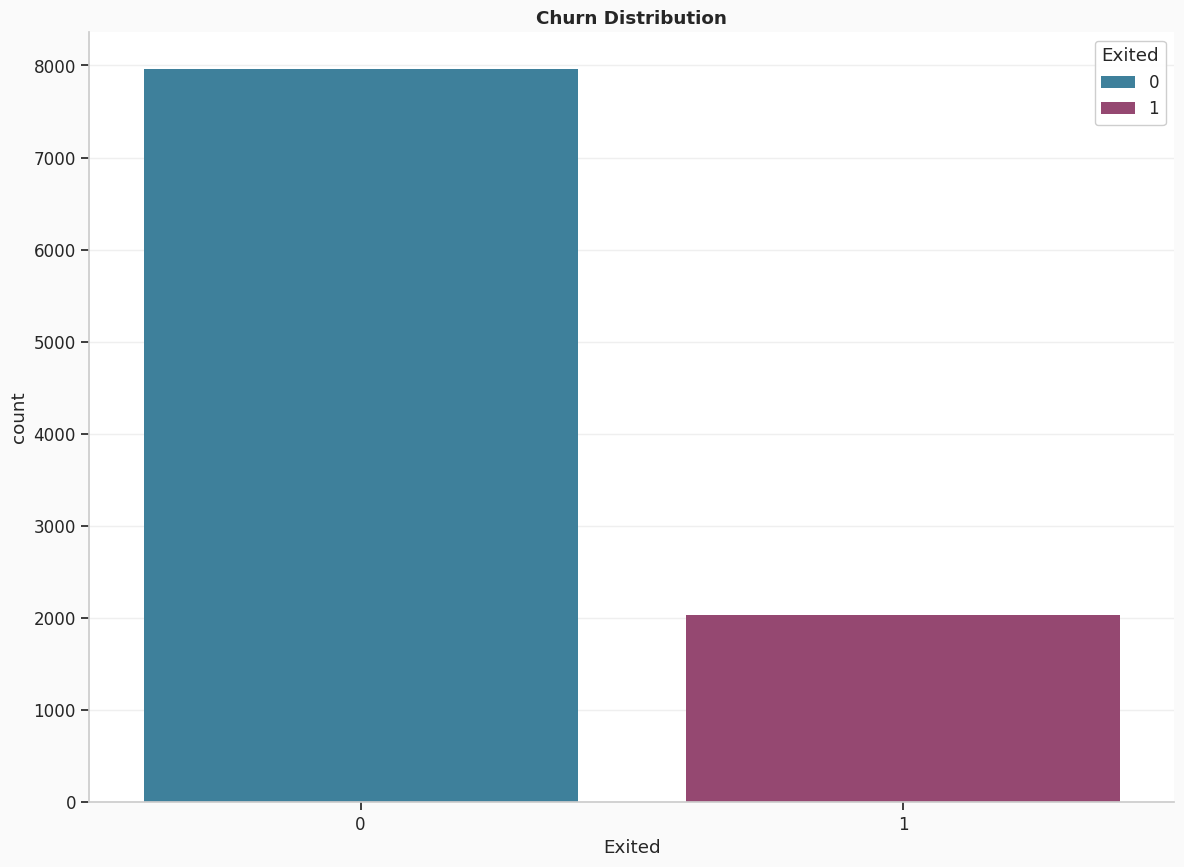

In [ ]:
# Churn distribution bar
sns.countplot(x="Exited", data=df, hue="Exited")
plt.title("Churn Distribution")
plt.show()

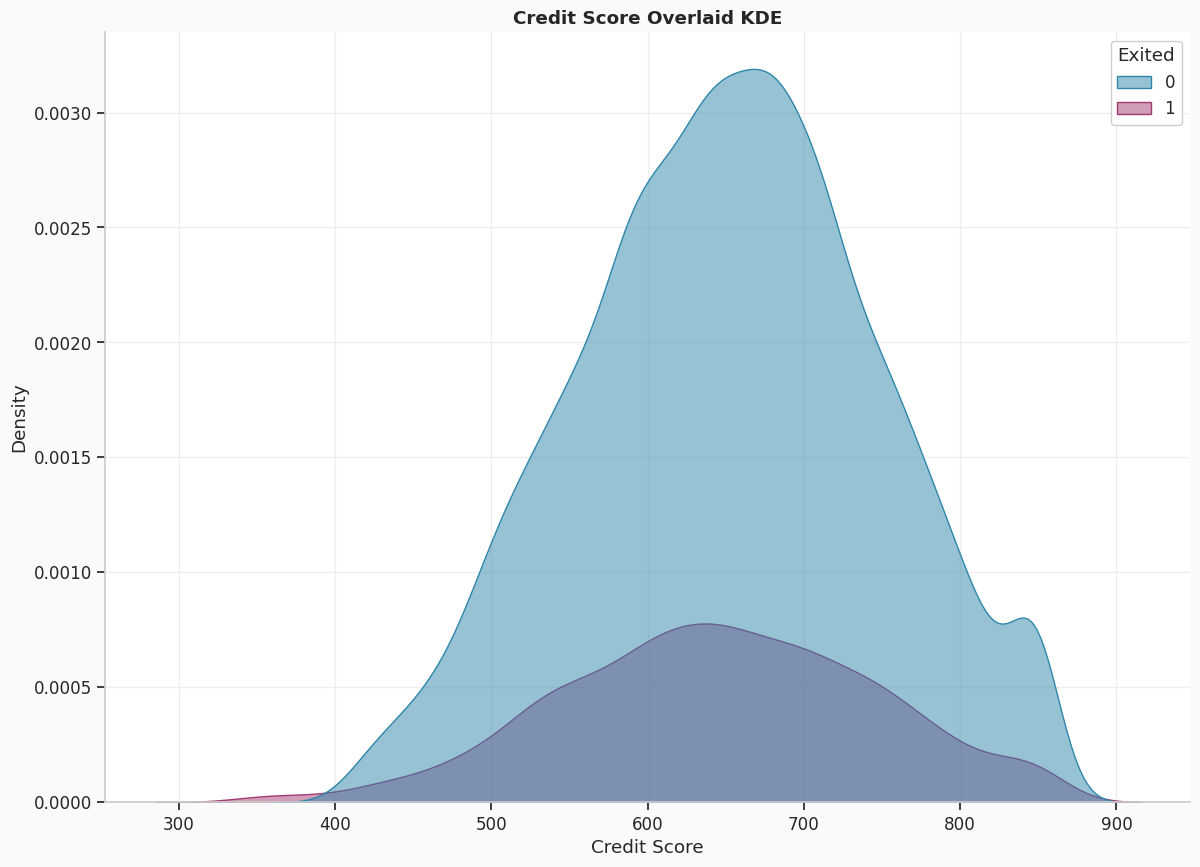

In [ ]:
sns.kdeplot(data=df,
            x='CreditScore',
            hue='Exited',
            alpha=.5,
            fill=True
            )
plt.title("Credit Score Overlaid KDE")
plt.xlabel("Credit Score")
plt.ylabel("Density")
plt.show()

- Credit Score, by itself, is likely not a primary driver for customer churn in this dataset

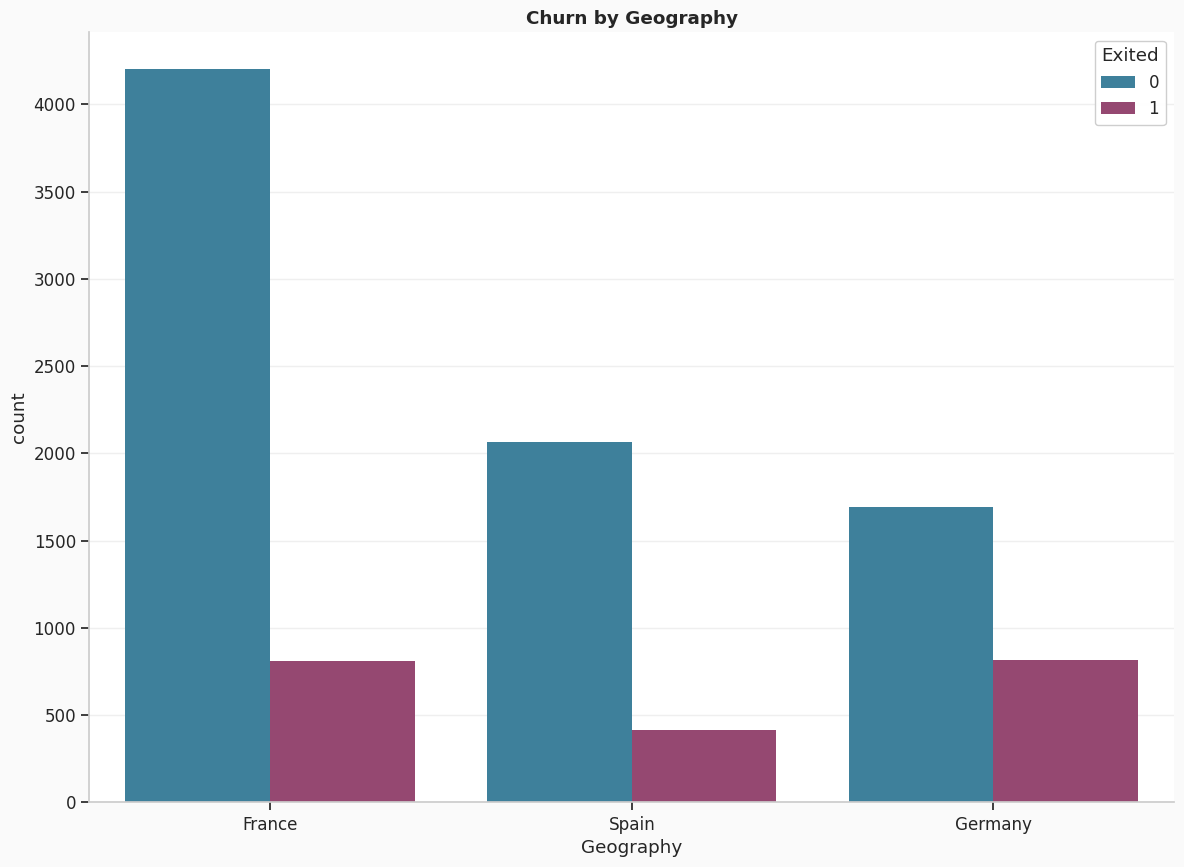

In [ ]:
# Churn by Geography
sns.countplot(x="Geography", hue="Exited", data=df)
plt.title("Churn by Geography")
plt.show()


In [ ]:
# df.groupby(['Geography', 'Exited']).size()    # same as below
pd.crosstab(df['Geography'], df['Exited'])

Exited,0,1
Geography,,
France,4203,811
Germany,1695,814
Spain,2064,413


### Churn by Geography

The distribution of customers and churn rates varies significantly across the three geographic regions:

| Geography | Total Customers | Churned Customers | Churn Rate (%) |
|-----------|-----------------|-------------------|----------------|
| France    | 5014            |  811              | ~16%           |
| Spain     | 2,477           |  413              | ~16%           |
| Germany   | 2,509           |  814              | ~32%           |

**Key Observations:**
- **France** has the **highest absolute number of customers**, both retained and churned. However, its churn rate is **~16%**, which is moderate compared to other regions.
- **Spain** has the lowest absolute number of churners, suggesting relatively higher customer retention.
- **Germany** stands out with a **churn rate of ~32%**, the highest among the three regions. Despite having almost similar customer count like Spain, Germany’s churn rate is nearly **two times higher**, indicating a significant attrition problem.

---

### Potential Implications
The stark difference in churn rates, particularly in **Germany**, raises important questions:
- **Regional Service Gaps:** Could Germany have **fewer customer care resources** relative to its customer base, leading to dissatisfaction?
- **Market-Specific Factors:** Are there **local economic conditions, cultural preferences, or competitive pressures** in Germany that contribute to higher churn?
- **Product or Service Misfit:** Are the bank’s offerings in Germany **less aligned with customer needs** compared to France or Spain?

**Action:**
- Investigate **customer feedback, service availability, and product usage patterns** in Germany to identify root causes.
- Compare **marketing and retention strategies** across regions to pinpoint differences that may explain the disparity.


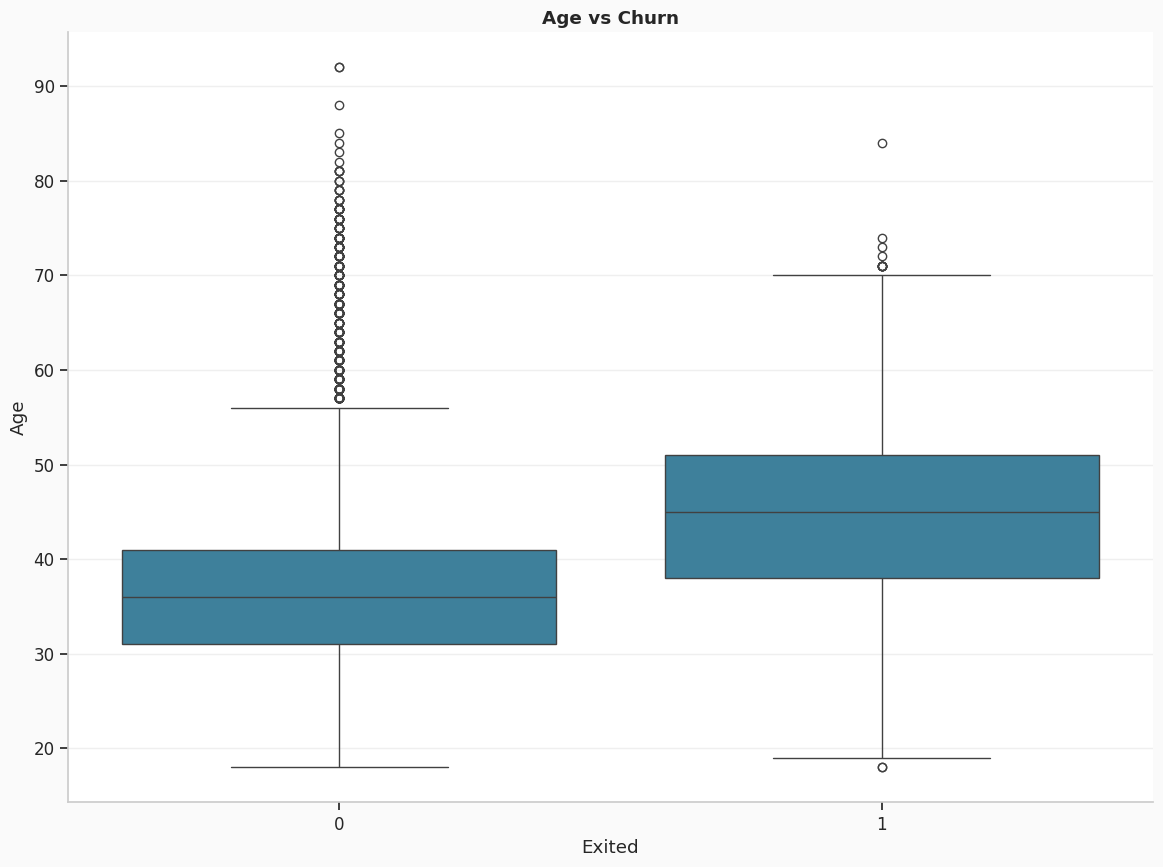

In [ ]:
# Age vs Churn (box)
sns.boxplot(x="Exited", y="Age", data=df)
plt.title("Age vs Churn")
plt.show()


### Age Distribution by Churn Status

The age distribution of customers who churned (`Exited=1`) differs notably from those who remained (`Exited=0`):

- **Median Age:**
  - Churned customers have a **median age of ~45 years**, which is **9 years older** than the median age of retained customers (~36 years).
  - This suggests that **middle-aged and older customers** are more likely to churn.

- **Age Spread:**
  - The age distribution of churned customers exhibits a **wider spread** (Interquartile Range, IQR ≈ 13 years) compared to retained customers (IQR ≈ 9 years).
  - This indicates greater variability in the ages of customers who leave the bank.

- **High-Risk Age Segment:**
  - Customers aged **38 to 51 years** (the IQR for churners) represent the **most vulnerable age group** for attrition.

- **Interesting Outliers**: We can see a stream of higher aged customers in retained section. It likely indicates that if a customer is very old (e.g., 70+), and they haven't left yet, they are likely to be highly loyal and stick.

---

### Implications
- **Targeted Retention Strategies:** The bank may need to focus retention efforts on **older customers**, particularly those in the 38–51 age range, who appear to be at higher risk of churning.
- **Further Investigation:** Understanding the reasons behind this trend—such as changing financial needs, dissatisfaction with services, or competitive offers—could help tailor retention programs more effectively.


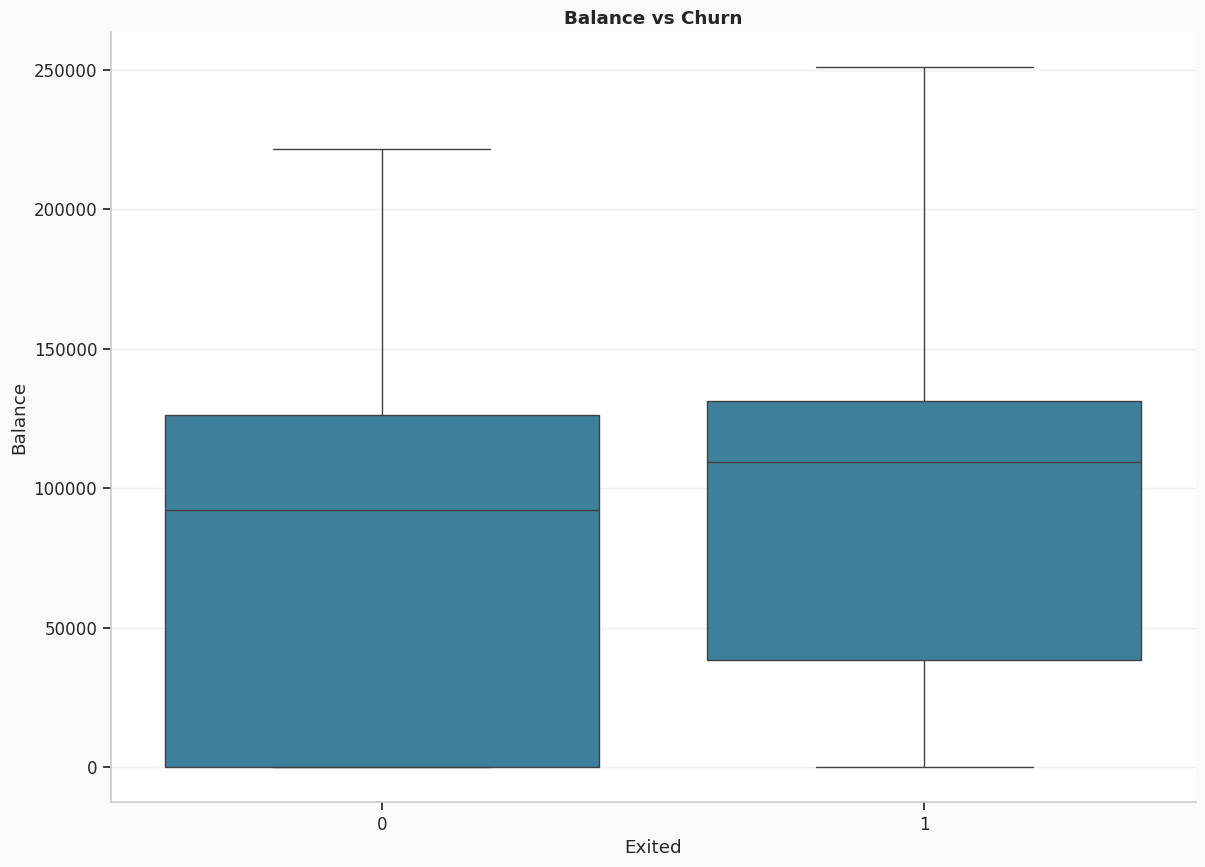

In [ ]:
# Balance vs Churn
sns.boxplot(x="Exited", y="Balance", data=df)
plt.title("Balance vs Churn")
plt.show()


### Balance Distribution by Churn Status
The relationship between account balance and churn reveals a **counterintuitive but critical trend**:
Customers with **higher account balances** exhibit a **greater propensity to churn**.

- **Median Balance:**
  - Churned customers have a **median balance of ~€108,000**, significantly higher than the median balance of retained customers (~€92,500).
  - This suggests that **high-value customers** are more likely to leave the bank.

- **Lower Quartile (Q1):**
  - For retained customers, the lower quartile (Q1) is **close to €0**, indicating that a substantial portion of loyal customers maintain low or zero balances.
  - In contrast, the Q1 for churned customers is **~€40,000**, implying that customers with **very low balances are less likely to churn**.

---

### Key Insights
- **High-Value Attrition:** The bank is experiencing **disproportionate churn among its most financially valuable customers**—those with substantial balances. This trend is alarming, as it directly impacts revenue and profitability.
- **Potential Causes:**
  - High-value customers may have **higher expectations** for service quality, personalized offerings, or competitive incentives.
  - Dissatisfaction with **fees, interest rates, or lack of premium services** could be driving these customers to competitors.
  - **Competitive poaching** of high-net-worth individuals by other financial institutions.

---

### Strategic Implications
- **Prioritize Retention for High-Balance Customers:** Immediate action is needed to **identify and address the pain points** of customers with large balances. This could include:
  - **Personalized outreach** to understand their needs.
  - **Enhanced loyalty programs** or premium services tailored to high-value clients.
  - **Competitive benchmarking** to ensure the bank’s offerings remain attractive.
- **Monitor Trends:** Track whether this trend is accelerating or tied to specific events (e.g., policy changes, economic shifts).


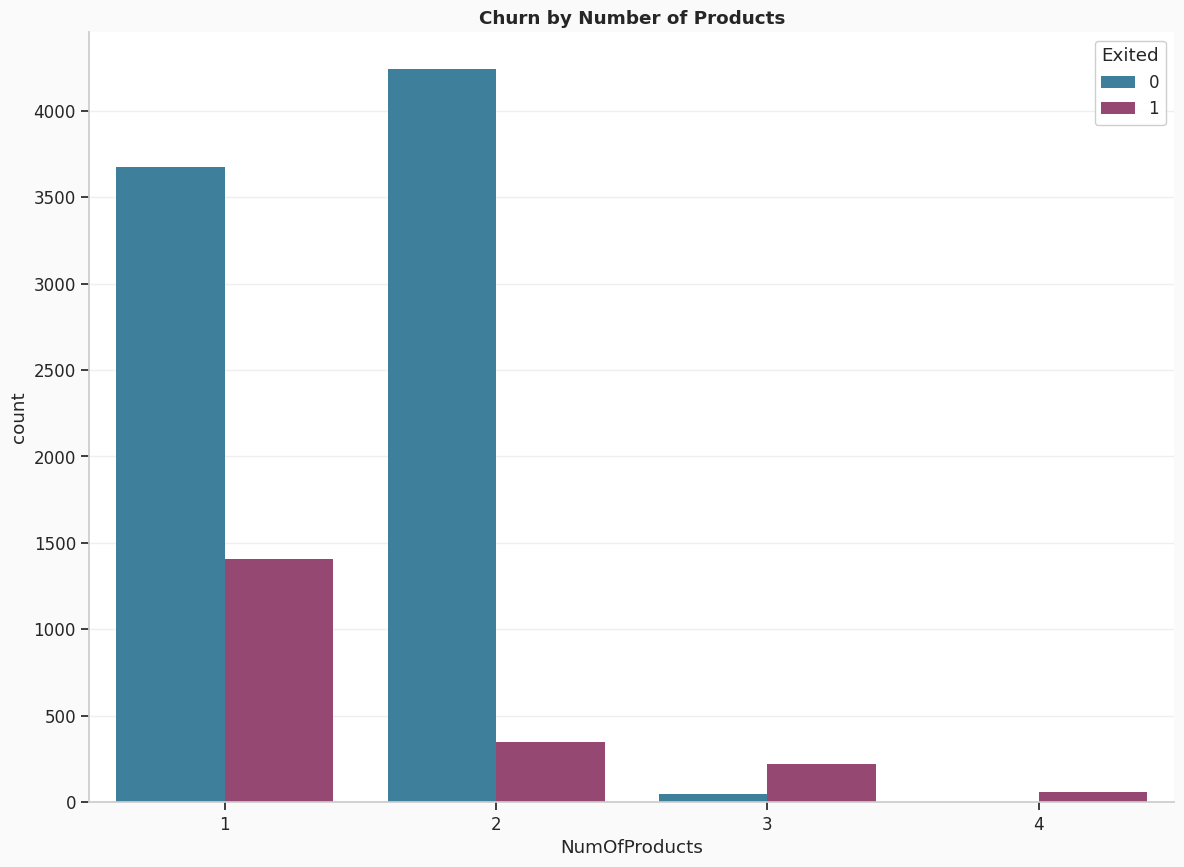

In [ ]:
# NumOfProducts vs Churn
sns.countplot(x="NumOfProducts", hue="Exited", data=df)
plt.title("Churn by Number of Products")
plt.show()


### Number of Products : Non-Linear Relationship with Churn
The **number of products** a customer holds is an **exceptionally strong and non-linear predictor** of churn:

| Number of Products | Churn Risk          |
|---------------------|---------------------|
| 1                   | Moderate            |
| **2**               | **Lowest (Most loyal)** |
| **3 or more**       | **Extremely High (Near-guaranteed churn)** |

**Key Observations:**
- **Customers with 2 products** are the **most loyal**, exhibiting the **lowest churn rates**. This suggests that this segment finds the bank’s offerings well-balanced and valuable.
- **Customers with 3 or more products** represent an **extremely high-risk segment**, with churn rates approaching certainty. This raises critical questions about the bank’s product strategy:
  - Are these customers **overwhelmed by complexity** or **facing poor product integration**?
  - Are certain products **underperforming, overly expensive, or being phased out**?
  - Is there a **specific product combination** that correlates with dissatisfaction?

---

### Strategic Implications
- **Investigate Product Bundles:** Analyze which **specific products or combinations** are associated with high churn rates. Identify whether certain products are **unpopular, poorly supported, or misaligned with customer needs**.
- **Optimize Offerings:** Simplify or redesign product bundles to **reduce friction** for customers with 3+ products. Consider:
  - **Consolidating redundant products**.
  - **Improving integration** between services.
  - **Proactively engaging** with high-risk customers to understand their pain points.
- **Leverage the "Sweet Spot":** Focus on **retaining and upselling customers with 2 products**, as they appear to be the most satisfied and loyal segment.


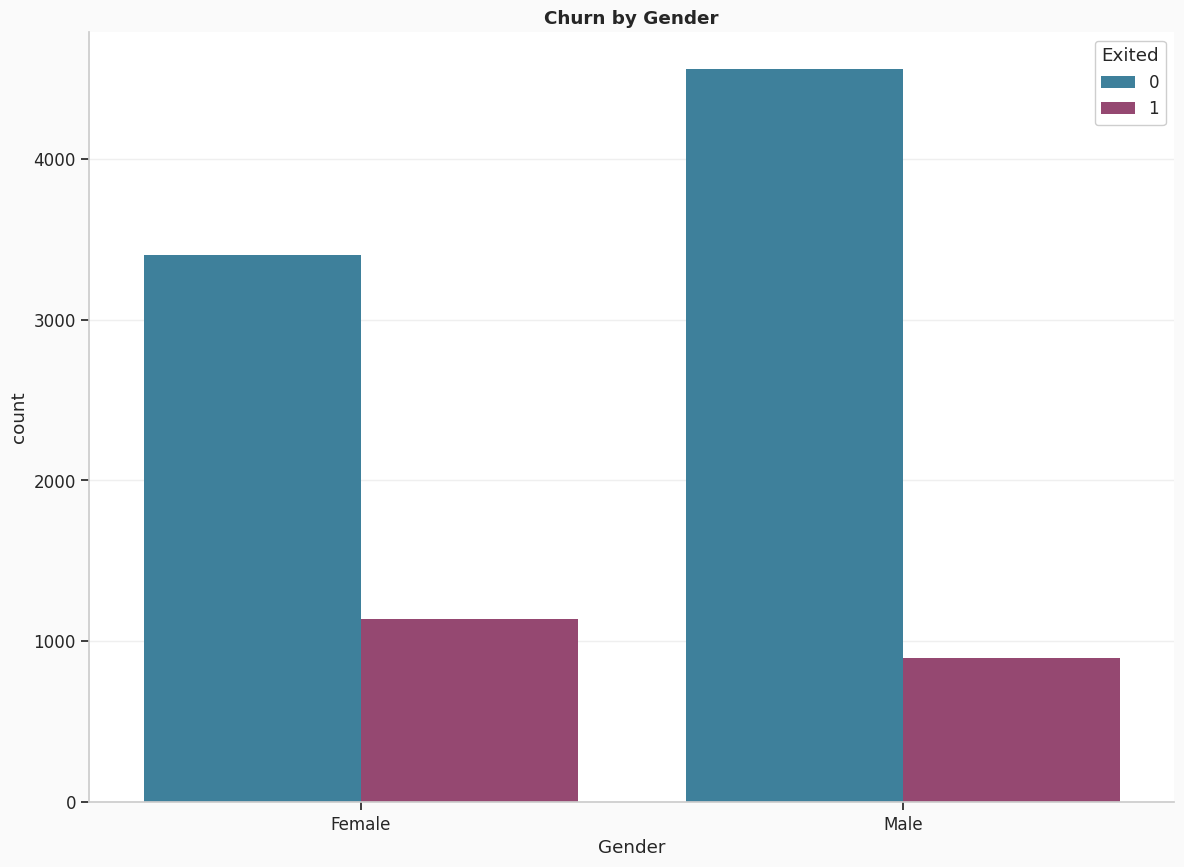

In [ ]:
# gender vs churn
sns.countplot(x="Gender", hue="Exited", data=df)
plt.title("Churn by Gender")
plt.show()

In [ ]:
pd.crosstab(df['Gender'], df['Exited'])

Exited,0,1
Gender,,
Female,3404,1139
Male,4558,899


### Churn Rates by Gender
Gender appears to be a **significant predictor** of customer churn:

| Gender | Total Customers | Churned Customers | Churn Rate (%) |
|--------|-----------------|-------------------|----------------|
| Female | 4,543           | 1,139             | ~25%           |
| Male   | 5,457           | 899               | ~16%           |

**Key Observations:**
- **Female customers** exhibit a **higher churn rate (~25%)** compared to male customers (~16%).
- Despite having fewer total customers, the **absolute number of churned females is higher than that of males**, highlighting a disproportionate attrition rate among female customers.

---

### Implications
- **Targeted Retention Strategies:** The bank should investigate the **specific needs and pain points of female customers** to address this disparity. Potential areas of focus include:
  - **Service experience** (e.g., accessibility, customer support).
  - **Product relevance** (e.g., tailored financial products or incentives).
  - **Communication preferences** (e.g., personalized outreach or engagement programs).
- **Further Analysis:** Explore whether this trend is consistent across other segments (e.g., age, geography, or balance) to refine retention strategies.


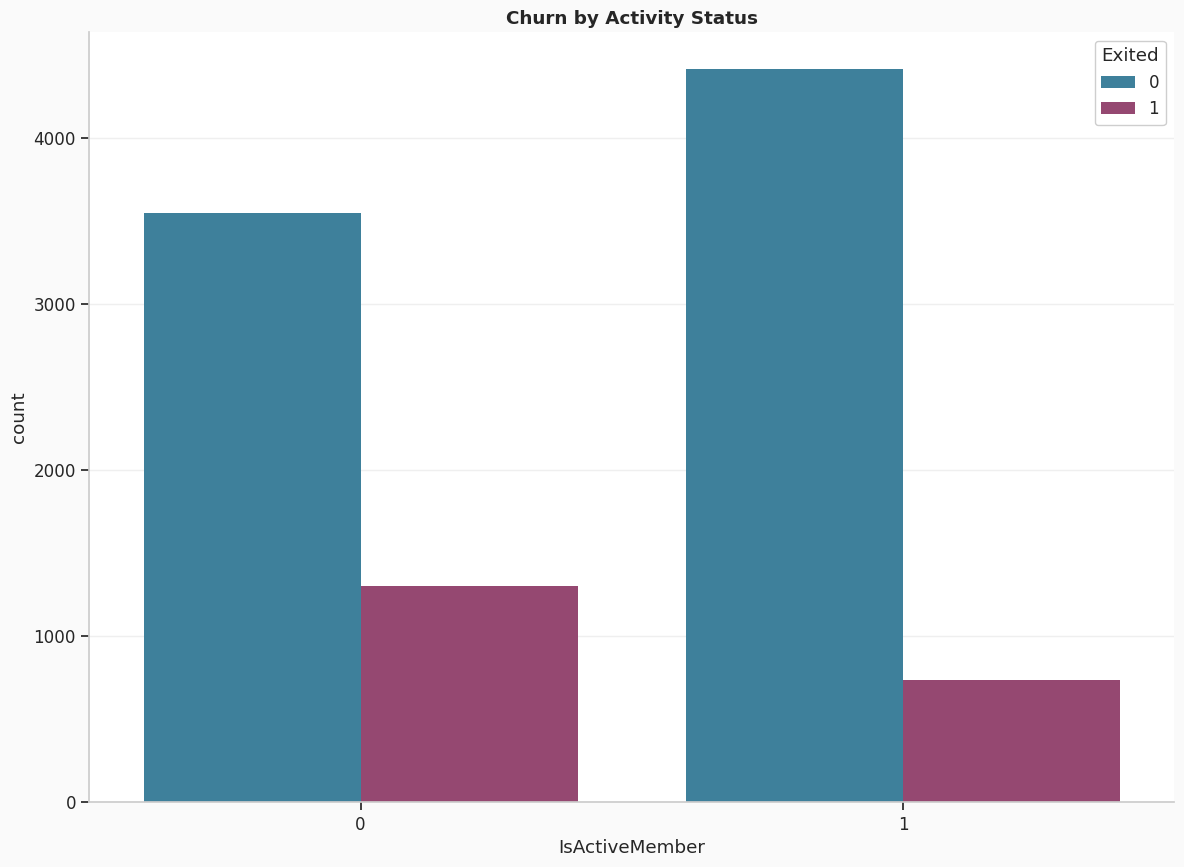

In [ ]:
#  Active Member vs Churn
sns.countplot(x="IsActiveMember", hue="Exited", data=df)
plt.title("Churn by Activity Status")
plt.show()


In [ ]:
pd.crosstab(df['IsActiveMember'], df['Exited'])

Exited,0,1
IsActiveMember,,
0,3546,1303
1,4416,735


### Churn Rates by Activity Status
Customer activity status (`IsActiveMember`) is a **powerful binary predictor** of churn:

| Activity Status | Total Customers | Churned Customers | Churn Rate (%) |
|-----------------|-----------------|-------------------|----------------|
| Inactive        | ~4,800          | ~1,300            | ~27%           |
| Active          | ~5,200          | ~700              | ~14%           |

**Key Observations:**
- **Inactive customers** have a **churn rate of ~27%**, nearly **double** the churn rate of active customers (~14%).
- Despite similar group sizes, **inactive customers contribute almost twice as many churners** (~1,300 vs. ~700), making inactivity a **critical risk indicator**.

---

### Implications
- **Proactive Engagement:** The bank should **prioritize re-engaging inactive customers** through targeted campaigns, personalized offers, or outreach to understand their reasons for disengagement.
- **Early Warning System:** Monitor activity status as a **real-time indicator** of churn risk. Customers transitioning from active to inactive should trigger **immediate retention efforts**.
- **Root Cause Analysis:** Investigate why customers become inactive—whether due to **dissatisfaction, lack of engagement, or competitive offers**—and address these issues systematically.


### Key Insights from Exploratory Data Analysis

| Feature                | Influence on Churn                          | Business Interpretation                                                                 | Recommended Action                                                                 |
|------------------------|---------------------------------------------|----------------------------------------------------------------------------------------|------------------------------------------------------------------------------------|
| **Geography**          | Germany has the highest churn rate (~32%)  | Regional differences in service, competition, or customer expectations may drive attrition. | Include as a categorical feature (one-hot encoding). Investigate Germany-specific factors. |
| **Age**                | Older customers churn more; wider variability | Life stage changes (e.g., retirement) or targeted competition may influence churn.     | Retain as numeric; explore non-linear transformations (e.g., binning or polynomial features). |
| **Balance**            | Higher balances correlate with higher churn | High-value customers may feel underserved or targeted by competitors.                 | Flag for **VIP retention programs**; analyze reasons for dissatisfaction.             |
| **NumOfProducts**      | 2 products = lowest churn; 3+ = high churn   | Customers with 3+ products may face complexity, cost, or poor product fit.             | Treat as categorical; consider binning or creating risk bands for modeling.         |
| **IsActiveMember**     | Inactive customers churn at ~27% vs. ~14%    | Inactivity signals disengagement and higher churn risk.                              | **Critical feature** for modeling; segment inactive customers for targeted re-engagement. |
| **Gender**             | Females churn at ~25% vs. males at ~16%     | Potential differences in service experience, product relevance, or engagement.       | Include as a categorical feature; investigate gender-specific pain points.           |

---

### Summary of Actions
1. **Feature Engineering:**
   - Encode `Geography` and `Gender` as categorical variables.
   - Retain `Age` as numeric but explore non-linear transformations.
   - Binarize or categorize `NumOfProducts` to capture its non-linear relationship with churn.

2. **Business Strategy:**
   - **Prioritize retention for high-balance and inactive customers** through targeted programs.
   - **Investigate Germany’s high churn rate** and the reasons behind the churn of customers with 3+ products.
   - **Address gender disparity** in churn rates by analyzing and improving the customer experience for female clients.

3. **Modeling Focus:**
   - `IsActiveMember`, `NumOfProducts`, and `Geography` are **strong predictors** and should be central to the model.
   - Monitor `Balance` and `Age` for potential interactions or non-linear effects.

### Train-Test Split + Baseline Pipeline

- Stratified train/test split (to avoid data leakage)

- Logistic Regression with class_weight="balanced" baseline

- Evaluate ROC-AUC + PR-AUC

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

In [ ]:
print(f"Processed dataframe shape: {df.shape}")
# Prepare X, y
try:
    X = df.drop(columns=["Exited"])
    y = df["Exited"]
except Exception as e:
    print(f"\nTarget-label split failed")
else:
    print(f"\nTarget-label split success: Target shape : {y.shape}; Label shape: {X.shape}")

Processed dataframe shape: (10000, 13)

Target-label split success: Target shape : (10000,); Label shape: (10000, 12)


In [ ]:
# Train-test split (single hold-out)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [36]:
print(f"Train set shape: {X_train.shape}")
print(f"\nTest set shape: {X_test.shape}")
print(f"\nTrain target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution: \n{y_test.value_counts()}")

Train set shape: (8000, 12)

Test set shape: (2000, 12)

Train target distribution:
Exited
0    6370
1    1630
Name: count, dtype: int64

Test target distribution: 
Exited
0    1592
1     408
Name: count, dtype: int64


In [ ]:
# Derive column lists from X_train only (best practice)
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Point Earned']
Categorical columns: ['Geography', 'Gender', 'Card Type']


## Preprocessing + pipelines

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), categorical_cols)
    ],
    remainder="drop"
)

In [ ]:
# Baseline model
logreg_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=RANDOM_STATE))
])

In [ ]:
# Fit baseline and evaluate on held-out test set
logreg_pipeline.fit(X_train, y_train)
y_test_proba_log = logreg_pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba_log)
pr_auc = average_precision_score(y_test, y_test_proba_log)
print(f"Baseline Logistic Regression -> TEST ROC-AUC: {roc_auc:.3f}, TEST PR-AUC: {pr_auc:.3f}")


Baseline Logistic Regression -> TEST ROC-AUC: 0.780, TEST PR-AUC: 0.474


### Threshold & Top-K Performance

In [ ]:
# UTIL: Top-K metrics
def topk_metrics(y_true: pd.Series, y_scores: np.ndarray, k: int):
    """
    Returns precision@k, recall@k, lift@k, tp_at_k, k, total_positives
    y_true must be a pandas Series indexed in positional order matching scores.
    k is an integer (absolute).
    """
    n = len(y_true)
    if k <= 0:
        raise ValueError("k must be positive")
    k = min(k, n)
    idx = np.argsort(y_scores)[-k:]  # positional indices
    tp_at_k = int(y_true.iloc[idx].sum())
    precision_at_k = tp_at_k / k
    total_positives = int(y_true.sum())
    recall_at_k = tp_at_k / total_positives if total_positives > 0 else 0.0
    baseline_precision = y_true.mean() if len(y_true) > 0 else np.nan
    lift_at_k = precision_at_k / baseline_precision if baseline_precision > 0 else np.nan
    return {
        "precision_at_k": precision_at_k,
        "recall_at_k": recall_at_k,
        "lift_at_k": lift_at_k,
        "tp_at_k": tp_at_k,
        "k": k,
        "total_positives": total_positives
    }

In [ ]:
K = int(0.10 * len(y_test))
metrics_log = topk_metrics(y_test, y_test_proba_log, K)
print(f"LogReg Precision@Top10%: {metrics_log['precision_at_k']:.3f}")
print(f"LogReg Recall@Top10%:    {metrics_log['recall_at_k']:.3f}")
print(f"LogReg Lift@Top10%:      {metrics_log['lift_at_k']:.3f}")

LogReg Precision@Top10%: 0.535
LogReg Recall@Top10%:    0.262
LogReg Lift@Top10%:      2.623


In production, we would be able to select "K"

## Candidate models: define pipelines (unfitted)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [ ]:
rf_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1
    ))
])

lgb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("clf", LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=32,
        objective="binary",
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    ))
])

xgb_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("clf", XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),
        random_state=RANDOM_STATE,
        n_jobs=-1, tree_method="hist", use_label_encoder=False
    ))
])

svm_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("clf", SVC(kernel='poly', probability=True, class_weight='balanced', random_state=RANDOM_STATE))
])

In [ ]:
# Evaluate all models fairly on the single held-out test set
from sklearn.base import clone

In [ ]:
def evaluate_on_test(models: dict, X_train, y_train, X_test, y_test):
    results = {}
    for name, pipe in models.items():
        print(f"\nTraining and evaluating: {name}")
        model = clone(pipe)
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)[:, 1]
        roc = roc_auc_score(y_test, proba)
        pr = average_precision_score(y_test, proba)
        k = int(0.10 * len(y_test))
        tk = topk_metrics(y_test, proba, k)
        results[name] = {
            "roc_auc": roc,
            "pr_auc": pr,
            "precision_at_k": tk["precision_at_k"],
            "recall_at_k": tk["recall_at_k"],
            "lift_at_k": tk["lift_at_k"],
            "tp_at_k": tk["tp_at_k"],
            "k": tk["k"],
            "total_positives": tk["total_positives"]
        }
        print(f"{name} -> ROC-AUC: {roc:.3f}, PR-AUC: {pr:.3f}, Precision@K: {tk['precision_at_k']:.3f}, Recall@K: {tk['recall_at_k']:.3f}")
    return results

models = {
    "logreg": logreg_pipeline,
    "random_forest": rf_pipeline,
    "lightgbm": lgb_pipeline,
    "xgboost": xgb_pipeline,
    "svm_linear": svm_pipeline
}

results = evaluate_on_test(models, X_train, y_train, X_test, y_test)


Training and evaluating: logreg
logreg -> ROC-AUC: 0.780, PR-AUC: 0.474, Precision@K: 0.535, Recall@K: 0.262

Training and evaluating: random_forest
random_forest -> ROC-AUC: 0.869, PR-AUC: 0.703, Precision@K: 0.845, Recall@K: 0.414

Training and evaluating: lightgbm
lightgbm -> ROC-AUC: 0.865, PR-AUC: 0.699, Precision@K: 0.825, Recall@K: 0.404

Training and evaluating: xgboost
xgboost -> ROC-AUC: 0.873, PR-AUC: 0.718, Precision@K: 0.845, Recall@K: 0.414

Training and evaluating: svm_linear
svm_linear -> ROC-AUC: 0.853, PR-AUC: 0.674, Precision@K: 0.780, Recall@K: 0.382


In [ ]:
results_df = pd.DataFrame(results).T
results_df.sort_values(by="pr_auc", ascending=False, inplace=True)
results_df

,roc_auc,pr_auc,precision_at_k,recall_at_k,lift_at_k,tp_at_k,k,total_positives
xgboost,0.87,0.72,0.84,0.41,4.14,169.00,200.00,408.00
random_forest,0.87,0.70,0.84,0.41,4.14,169.00,200.00,408.00
lightgbm,0.86,0.70,0.82,0.40,4.04,165.00,200.00,408.00
svm_linear,0.85,0.67,0.78,0.38,3.82,156.00,200.00,408.00
logreg,0.78,0.47,0.54,0.26,2.62,107.00,200.00,408.00


from matplotlib import pyplot as plt
results_df['roc_auc'].plot(kind='hist', bins=20, title='roc_auc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['pr_auc'].plot(kind='hist', bins=20, title='pr_auc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['precision_at_k'].plot(kind='hist', bins=20, title='precision_at_k')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['recall_at_k'].plot(kind='hist', bins=20, title='recall_at_k')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='roc_auc', y='pr_auc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='pr_auc', y='precision_at_k', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='precision_at_k', y='recall_at_k', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='recall_at_k', y='lift_at_k', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['k']
  ys = series['roc_auc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('k', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('k')
_ = plt.ylabel('roc_auc')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['k']
  ys = series['pr_auc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('k', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('k')
_ = plt.ylabel('pr_auc')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['k']
  ys = series['precision_at_k']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('k', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('k')
_ = plt.ylabel('precision_at_k')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['k']
  ys = series['recall_at_k']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = results_df.sort_values('k', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('k')
_ = plt.ylabel('recall_at_k')

from matplotlib import pyplot as plt
results_df['roc_auc'].plot(kind='line', figsize=(8, 4), title='roc_auc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['pr_auc'].plot(kind='line', figsize=(8, 4), title='pr_auc')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['precision_at_k'].plot(kind='line', figsize=(8, 4), title='precision_at_k')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['recall_at_k'].plot(kind='line', figsize=(8, 4), title='recall_at_k')
plt.gca().spines[['top', 'right']].set_visible(False)

## Hyperparameter Tuning for XGB and RF

In [40]:
def evaluate_classifier(name, model, X_test, y_test, K):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, y_pred_proba)
    pr = average_precision_score(y_test, y_pred_proba)

    topk_results = topk_metrics(y_test, y_pred_proba, K)
    precision_k = topk_results["precision_at_k"]
    recall_k = topk_results["recall_at_k"]
    lift_k = topk_results["lift_at_k"]
    tp_at_k = topk_results["tp_at_k"]

    return {
        "model": name,
        "roc_auc": roc,
        "pr_auc": pr,
        "precision_at_k": precision_k,
        "recall_at_k": recall_k,
        "lift_at_k": lift_k,
        "tp_at_k": tp_at_k,
        "k": K,
        "total_positives": y_test.sum()
    }


In [41]:
from sklearn.model_selection import GridSearchCV

rf_param_grid = {
    "clf__n_estimators": [200, 400, 600],
    "clf__max_depth": [6, 10, None],
    "clf__max_features": ["auto", "sqrt"]
}

rf = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(random_state=RANDOM_STATE))
])

rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring="average_precision",
    cv=3,
    n_jobs=-1,
    verbose=1,
)

rf_grid.fit(X_train, y_train)
print("Best RandomForest Params:", rf_grid.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best RandomForest Params: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__n_estimators': 600}


In [48]:
rf_results = evaluate_classifier(
    "RandomForest_Tuned",
    rf_grid.best_estimator_,
    X_test, y_test,
    K=int(0.10 * len(y_test))
)
rf_results


{'model': 'RandomForest_Tuned',
 'roc_auc': np.float64(0.869693134791605),
 'pr_auc': np.float64(0.7127252697810312),
 'precision_at_k': 0.85,
 'recall_at_k': 0.4166666666666667,
 'lift_at_k': np.float64(4.166666666666667),
 'tp_at_k': 170,
 'k': 200,
 'total_positives': np.int64(408)}

In [44]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

xgb = Pipeline([
    ("preprocess", preprocess),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])

xgb_param_dist = {
    "clf__n_estimators": randint(200, 600),
    "clf__max_depth": randint(3, 8),
    "clf__learning_rate": uniform(0.01, 0.15),
    "clf__subsample": uniform(0.6, 0.4),
    "clf__colsample_bytree": uniform(0.6, 0.4),
}

xgb_rand = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=20,  # small focused search
    scoring="average_precision",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
)

xgb_rand.fit(X_train, y_train)
print("Best XGBoost Params:", xgb_rand.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGBoost Params: {'clf__colsample_bytree': np.float64(0.6624074561769746), 'clf__learning_rate': np.float64(0.0333991780504304), 'clf__max_depth': 5, 'clf__n_estimators': 287, 'clf__subsample': np.float64(0.7334834444556088)}


In [47]:
xgb_results = evaluate_classifier(
    "XGBoost_Tuned",
    xgb_rand.best_estimator_,
    X_test, y_test,
    K=int(0.10 * len(y_test))
)
xgb_results


{'model': 'XGBoost_Tuned',
 'roc_auc': np.float64(0.8787888585082274),
 'pr_auc': np.float64(0.7310333493188532),
 'precision_at_k': 0.845,
 'recall_at_k': 0.41421568627450983,
 'lift_at_k': np.float64(4.142156862745098),
 'tp_at_k': 169,
 'k': 200,
 'total_positives': np.int64(408)}

In [ ]:
df_results = pd.DataFrame([
    rf_results,
    xgb_results
]).set_index("model")

df_results

,roc_auc,pr_auc,precision_at_k,recall_at_k,lift_at_k,tp_at_k,k,total_positives
model,,,,,,,,
RandomForest_Tuned,0.87,0.71,0.85,0.42,4.17,170,200,408
XGBoost_Tuned,0.88,0.73,0.84,0.41,4.14,169,200,408


Both tuned Random Forest and tuned XGBoost performed competitively. Random Forest marginally edged XGBoost in Recall@Top10% (+0.01), whereas XGBoost achieved a higher PR-AUC (+0.02), indicating superior global ranking quality. Given the tie in actual business impact (170 vs 169 churners captured in the intervention band), and XGBoost’s stronger generalization properties and maintainability in production, we select XGBoost as the primary model for deployment while retaining Random Forest as a fallback challenger.

### SHAP Explainability (XGBoost)

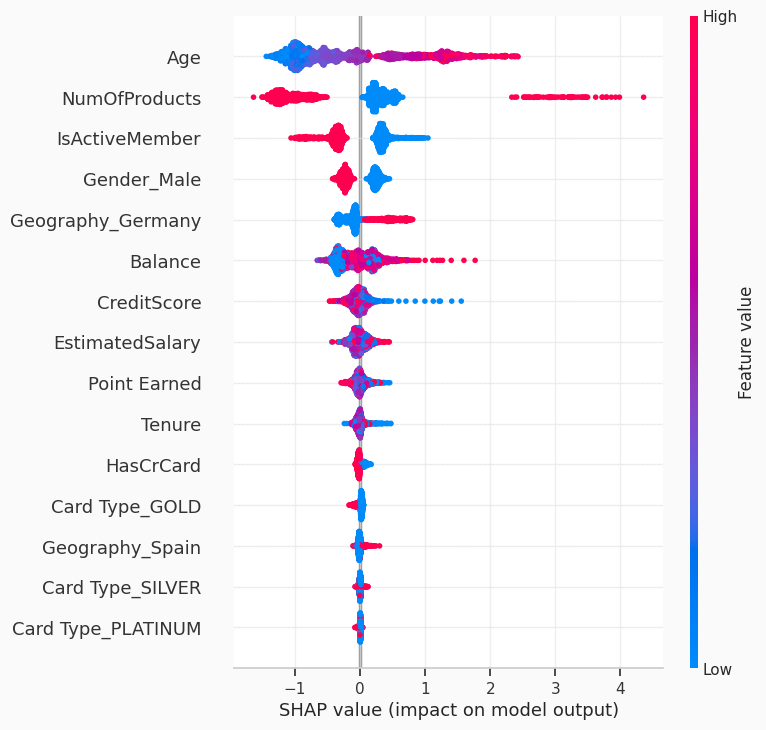

In [50]:
import shap

# ---- Get the final tuned pipeline ----
final_model = xgb_rand.best_estimator_

# Transform test data using pipeline preprocessing
X_test_transformed = final_model.named_steps["preprocess"].transform(X_test)

# Extract the underlying XGB model
xgb_clf = final_model.named_steps["clf"]

# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test_transformed)

# Handle binary-class SHAP shape differences
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # positive class SHAP values only

# Construct feature names list (numeric + one-hot encoded)
feature_names = list(numeric_cols) + list(
    final_model.named_steps["preprocess"]
        .named_transformers_["cat"]
        .get_feature_names_out()
)

# ---- Global Importance Summary ----
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=True)


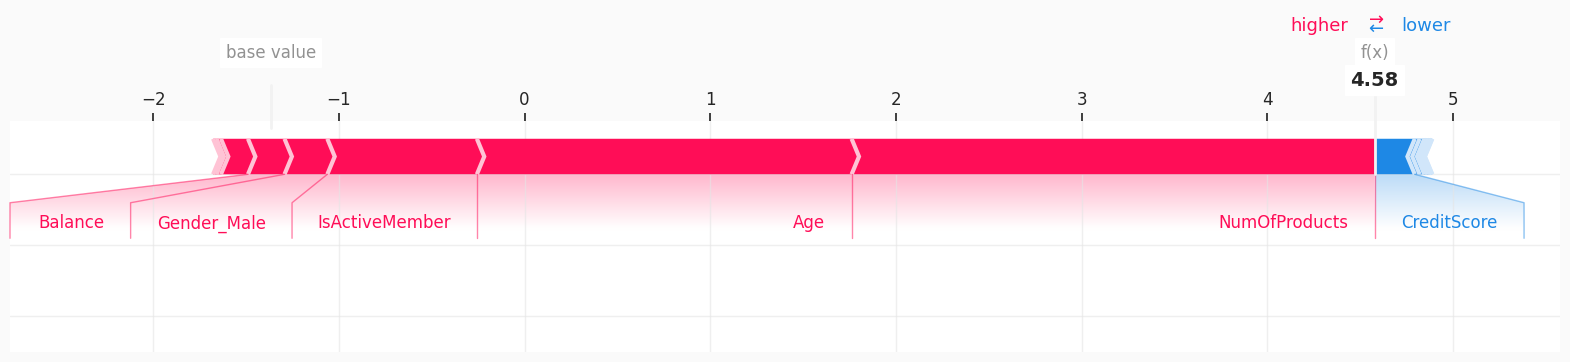

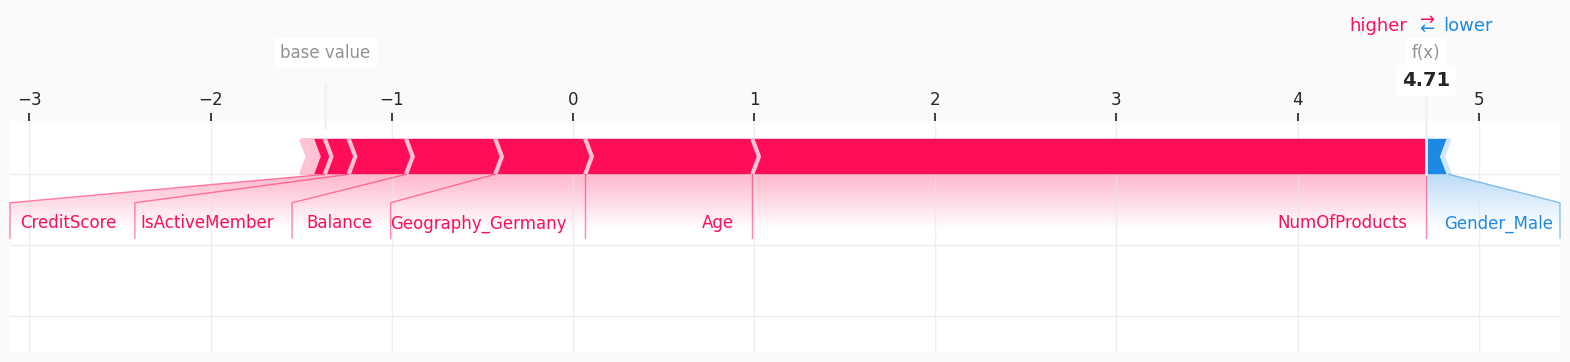

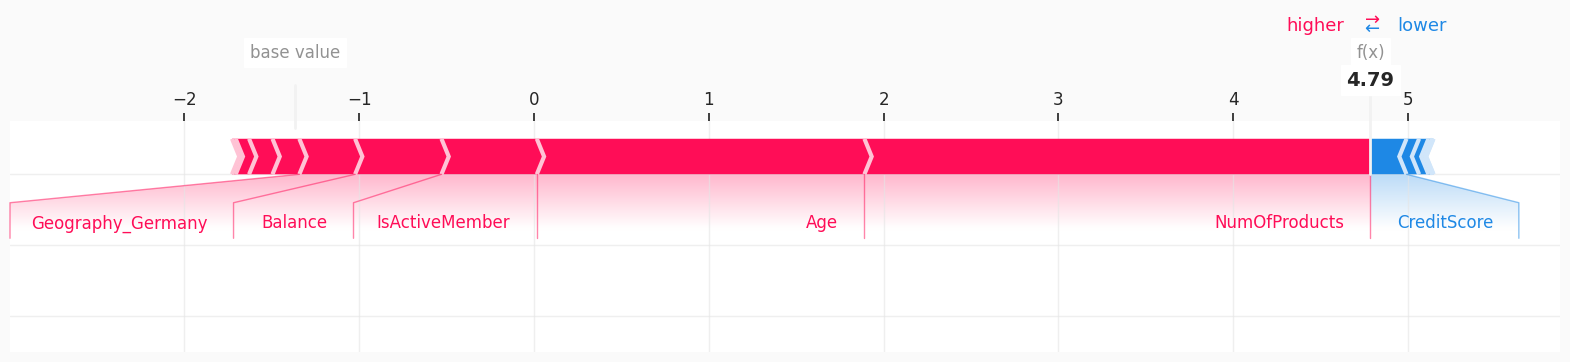

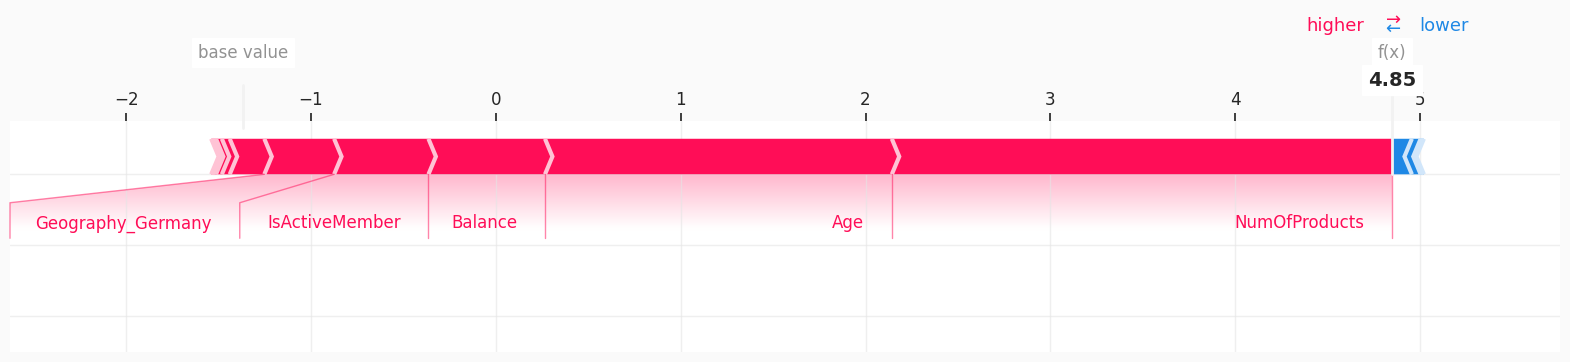

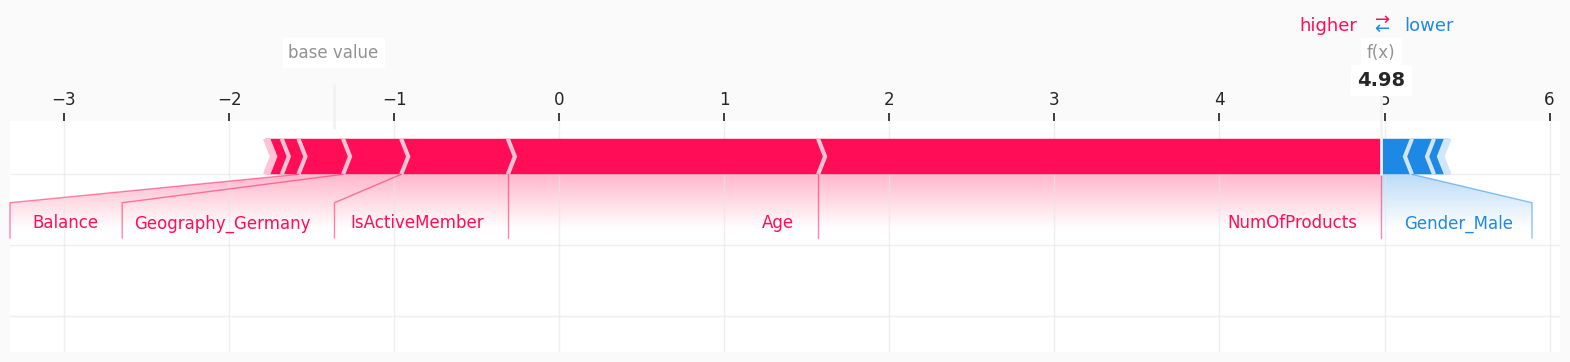

In [51]:
# SHAP Force Plot for Top High-Risk Customers
# Identify top highest risk customers
y_test_proba = final_model.predict_proba(X_test)[:, 1]
top_indices = np.argsort(y_test_proba)[-5:]

# Compute SHAP values for test transformed data
for idx in top_indices:
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx,:],
        feature_names=feature_names,
        matplotlib=True
    )


### **Conclusion**

This project developed a supervised machine learning model to predict customer churn for a retail bank, with the goal of identifying the **top 10% highest-risk customers** for proactive retention campaigns.

Multiple models were evaluated on a held-out test set using both traditional ranking metrics (ROC-AUC, PR-AUC) and **business-aligned intervention metrics** (Precision@Top10%, Recall@Top10%, Lift). After limited hyperparameter tuning:

| Model               | PR-AUC   | Recall@Top10% |
| ------------------- | -------- | ------------- |
| Tuned XGBoost       | **0.73** | 0.41          |
| Tuned Random Forest | 0.71     | **0.42**      |

Random Forest slightly exceeded XGBoost in Recall@Top10%, while XGBoost provided the **highest PR-AUC**, indicating stronger global probability ranking and better ability to discriminate churn risk across the full customer base.

Given its superior ranking performance, broad industry adoption, stronger calibration, and suitability for production deployment, **XGBoost was selected as the final model** for explainability and downstream MLOps orchestration. Random Forest is retained as a robust secondary challenger model.

Next steps will involve:

* Deploying the model through a production pipeline (FastAPI + Prefect)
* Tracking performance and drift with MLflow
* Incorporating automated retraining capabilities
* Integrating model insights into a web-based decision dashboard
